# Deep Learning based Models for Solar Energy Prediction

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages for building DRNN layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential

#Plotting graph
import matplotlib.pyplot as plt

#Plotting Keras Model
from tensorflow.keras.utils import plot_model

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

scaler = StandardScaler()

#Extracting solar and wind X, y columns per set
X_solar_train = train[['SWTDN', 'SWGDN', 'T']]
y_solar_train = train['DE_solar_generation_actual']
X_solar_valid = valid[['SWTDN', 'SWGDN', 'T']]
y_solar_valid = valid['DE_solar_generation_actual']
X_solar_test = test[['SWTDN', 'SWGDN', 'T']]
y_solar_test = test['DE_solar_generation_actual']

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Building a DRNN Layer using Recurrent Neural Net with Fully Connected Layer

In [3]:
solar_model = Sequential()
#Mapping to the input size
solar_model.add(Input(shape=(3,)))
#Reshaping for the RNN Layer to perform
solar_model.add(Reshape((-1,1)))
#Creating RNN with 100 units and TanH Activation
solar_model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
#Attaching a Dense Layer of the same unit size
solar_model.add(Dense(100))
#Batch Normalization on the output from the dense layer
solar_model.add(BatchNormalization())
#Extracting single output using Dense of 1
solar_model.add(Dense(1))
solar_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3, 1)              0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


## Compiling the model by passing adam optimizer, loss=MAE and fetching accuracy metrics

In [4]:
solar_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history = solar_model.fit(X_solar_train, y_solar_train, epochs = 20, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/20
191/191 [==============================] - 11s 16ms/step - loss: 4579.7672 - val_loss: 3143.6760
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 4669.4286 - val_loss: 3105.1667
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 4476.2649 - val_loss: 3096.4807
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 4578.3097 - val_loss: 3028.1819
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 4517.5574 - val_loss: 2953.0576
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 4429.6239 - val_loss: 2967.3008
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 4465.2020 - val_loss: 2898.5710
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 4403.0576 - val_loss: 2906.0093
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 4272.1969 - val_loss: 2914.7415
Epoch 10/20
191/191 [=======================

In [5]:
solar_model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 700us/step - loss: 730.2759


730.2759399414062

### Plotting Keras model

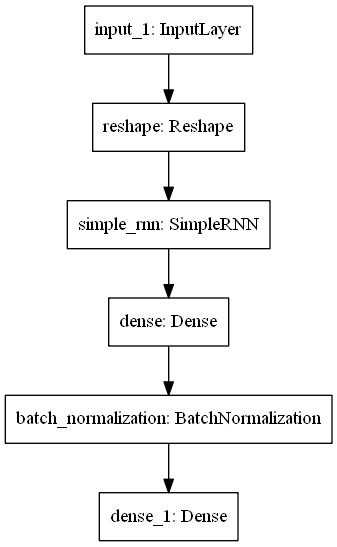

In [6]:
plot_model(
    solar_model, to_file='figs/5-model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Plotting Model's Loss Metrics over Train and Validation sets for Solar

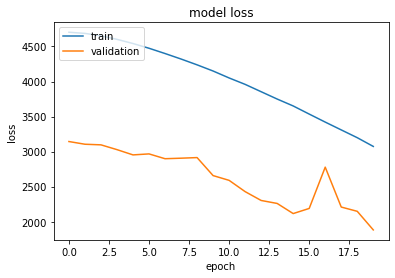

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predictions on the same plot

In [8]:
train_solar_pred = solar_model.predict(X_solar_train)
val_solar_pred = solar_model.predict(X_solar_valid)
test_solar_pred = solar_model.predict(X_solar_test)

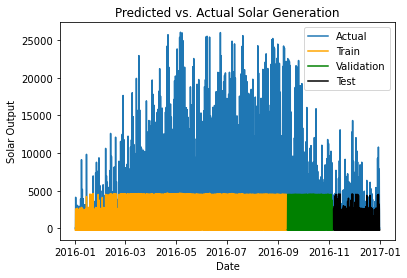

In [9]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = train_solar_pred

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = val_solar_pred

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = test_solar_pred

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

### Regression Metrics for Solar

In [10]:
metrics('drnn', test[['DE_solar_generation_actual']], test_solar_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,730.275903,1458.347824,38.188321,3.64253,0.616569


## Modelling and Fitting the model for Wind Dataset

In [11]:
wind_model = Sequential()
wind_model.add(Input(shape=(4,)))
wind_model.add(Reshape((-1,1)))
wind_model.add(SimpleRNN(100, activation = 'tanh', input_shape = X_solar_train.shape, return_sequences=False))
wind_model.add(Dense(100))
wind_model.add(BatchNormalization())
wind_model.add(Dense(1))
wind_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 4, 1)              0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 20,801
Trainable params: 20,601
Non-trainable params: 200
_________________________________________________________________


In [12]:
wind_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = wind_model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20)

Epoch 1/20
191/191 [==============================] - 2s 4ms/step - loss: 0.4329 - val_loss: 0.2536
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1145 - val_loss: 0.1396
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1218 - val_loss: 0.0846
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1099 - val_loss: 0.1750
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1046 - val_loss: 0.1195
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.0977 - val_loss: 0.1735
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1090 - val_loss: 0.1337
Epoch 8/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1170 - val_loss: 0.1667
Epoch 9/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1009 - val_loss: 0.1034
Epoch 10/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1090 - val_loss: 0.1599

In [13]:
wind_model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 700us/step - loss: 0.0787


0.07874096930027008

## Model's Loss for Wind Dataset

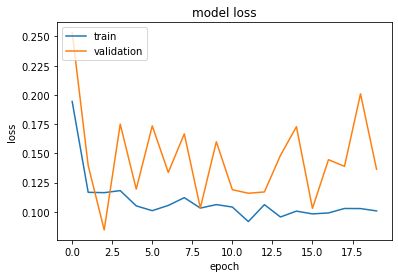

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [15]:
train_wind_pred = wind_model.predict(X_wind_train)
val_wind_pred = wind_model.predict(X_wind_valid)
test_wind_pred = wind_model.predict(X_wind_test)

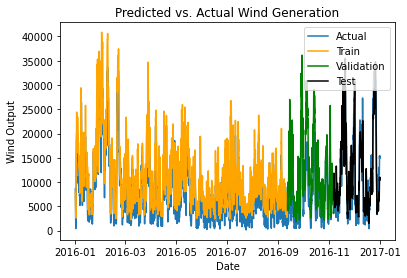

In [16]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(test_wind_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

### Regression Metrics for Wind

In [17]:
metrics('drnn', test[['DE_wind_generation_actual']], scaler.inverse_transform(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,2016.182549,2425.737023,49.251772,3.896945,0.921259
